# *Nb #2* - Multidimensional data: how many threads can / should we use?


## Introduction

Last time we looked at how to write a kernel and what the performance benefits of using a GPU over a CPU are. For both the test code and the assignment we primarilly used threads spread out in a linear grid (x direction). That's a big improvement over sequential processing, but if the data stretches multiple dimensions, it sometimes makes sense to reflec that in the spatial distribution of threads. 

In this notebook we will look at how to use threads and blocks in a 2D grid, what happens when we run out of threads, and how to overcome that without hardcoding. We will also look at the GPU's architecture more in detailm based on which you will establish an optimal thread count during your assignments.

## Striding

Imagine having a large dataset and an insufficient number of threads to cover it entirely. To avoid loosing the overhead data or manually calling the kernel on several parts of the data, striding is used to assign an a single thread to multiple samples of the dataset. Since now a single thread has to loop over several values, striding will also increase the execution time of the kernel. 


<img src="./Image/striding.png" alt="Striding overview." style="width: 750px; padding: 20px"/>


To show this in practice, let's first recap on what we did in the previous notebook before adding striding to the kernel.

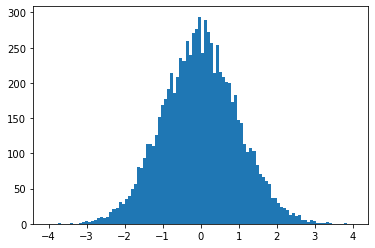

In [1]:
import time

from numba import cuda

import numpy as np # Arrays in Python
from matplotlib import pyplot as plt # Plotting library


@cuda.jit
def kernel_parallel(samples, xmin, xmax, histogram_out):
    '''Use the GPU for generateing a histogram. In parallel.'''

    # Calculate the thread's absolute position within the grid
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    
    # Calc the resolution of the histogram
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    # Associate each sample in the interval [xmin, xmax) with a bin and update the histogram. Skip outliers.
    bin_number = int((samples[x] - xmin) / bin_width)
    if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            cuda.atomic.add(histogram_out, bin_number, 1) # Prevent race conditions

            
NUMBER_OF_SAMPLES = 8_192
            

# Repeatable results
np.random.seed(0)

# Define the observed signal
signal = np.random.normal(size=8_192, loc=0, scale=1).astype(np.float32)

            
# Define the range
xmin = -4
xmax = 4

# Number of histogram elements = bins
nbins = 100

# Initiate an empty histogram
histogram_out = np.zeros(nbins)

threads = 512 # Per block
blocks = int(NUMBER_OF_SAMPLES / threads) # Cover all of the data

# We're not timing the function, so just call it once to get the histogram
kernel_parallel[blocks, threads](signal, xmin, xmax, histogram_out)


# Calculate x-axis values for plotting reasons (we also need to recalculate the bin width)
bin_width = (xmax - xmin) / nbins
x_vals = np.linspace( xmin, xmax, nbins, endpoint=False ) + bin_width/2

# Plot the histogram
plt.bar( x_vals, histogram_out, width=bin_width )
plt.show()

Okay, that all works nicely. Now let's pretend that we can only use 4 blocks, giving us a total of 2048 threads. We do that by setting the block count to 4.

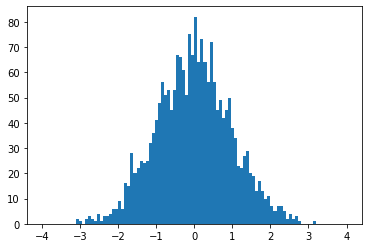

In [2]:
# Reset histogram
histogram_out = np.zeros(nbins)

# Set the number of thread blocks to 4
blocks = 4 

# We're not timing the function, so just call it once to get the histogram
kernel_parallel[blocks, threads](signal, xmin, xmax, histogram_out)


# Calculate x-axis values for plotting reasons (we also need to recalculate the bin width)
bin_width = (xmax - xmin) / nbins
x_vals = np.linspace( xmin, xmax, nbins, endpoint=False ) + bin_width/2

# Plot the histogram
plt.bar( x_vals, histogram_out, width=bin_width )
plt.show()

Not the result we were expecting any more! That's because only a portion of the samples were iterated. Now let's implement a stride loop. Our goal is to run each thread $N$-times, where:

$N = \dfrac{Number\_of\_samples}{Number\_of\_threads}$

In our case $N=4$.

In [3]:
@cuda.jit
def kernel_parallel_strided(samples, xmin, xmax, histogram_out):
    '''Use the GPU for generateing a histogram. In parallel.'''

    # Calculate the thread's absolute position within the grid
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    
    # Calc the resolution of the histogram
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    # Set stride equal to the number of threads we have available in the x-direction
    stride = cuda.gridDim.x * cuda.blockDim.x
    
    for i in range(x, samples.shape[0], stride):
        # Associate each sample in the interval [xmin, xmax) with a bin and update the histogram. Skip outliers.
        bin_number = int((samples[i] - xmin) / bin_width) # 'samples[i]' instead of 'samples[x]'
        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
                cuda.atomic.add(histogram_out, bin_number, 1) # Prevent race conditions

In the above kernel each thread attends to the sample at it's own index (`x`), the sample at `x + stride`, `x + 2*stride`, `x + n*stride` ... as long as `x + n*stride` actually represents an index of a sample. In other words, the stride loop will run sequentially till we run our of samples.

There are two main benefits to using the stride loop:
1. If a sufficient number of threads is used, the loop only executes once and the execution time remains small
2. Should there be too many threads, the statement also prevents the excess threads from writing to other parts of the memory

Now let's calculate the histogram again:

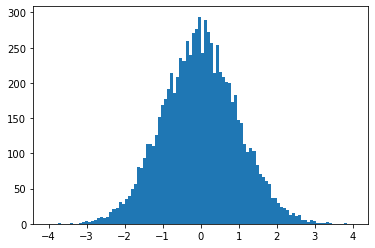

In [4]:
# Reset histogram
histogram_out = np.zeros(nbins)

# We're not timing the function, so just call it once to get the histogram
kernel_parallel_strided[blocks, threads](signal, xmin, xmax, histogram_out)


# Calculate x-axis values for plotting reasons (we also need to recalculate the bin width)
bin_width = (xmax - xmin) / nbins
x_vals = np.linspace( xmin, xmax, nbins, endpoint=False ) + bin_width/2

# Plot the histogram
plt.bar( x_vals, histogram_out, width=bin_width )
plt.show()

## Processing multidimensional data

Up to this point we've only considered an input stream of samples. In the following example we will switch from a 1D array to a 2D array by calculating the histogram of an image. First import the test image:

In [5]:
from PIL import Image
import requests

# Fetch image from URL
url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
image = Image.open(requests.get(url, stream=True).raw)

# Convert image to numpy array
image_array = np.asarray(image, dtype=np.int64)

# Convert to grayscale
image_array_gs = np.sum(np.asarray(image), axis=2) / 3

print(image_array_gs.shape)

(512, 512)


#### Using a 2D grid (grayscale)

Th original image is 3D (RGB), so we've bluntly converted it to grayscale. After checking it's output dimensions are 2D, proceed with the new kernel definition:

In [6]:
@cuda.jit
def kernel_2D(samples, xmin, xmax, histogram_out):
    '''Use the GPU for generateing a histogram of 2D input data.'''

    # Calculate the thread's absolute position within the grid
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    
    # Set stride equal to the number of threads we have available in either direction
    stride_x = cuda.gridDim.x * cuda.blockDim.x
    stride_y = cuda.gridDim.y * cuda.blockDim.y
    
    # Calc the resolution of the histogram
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    for i in range(x, samples.shape[0], stride_x):
        for j in range(y, samples.shape[1], stride_y):
            # Associate each sample in the interval [xmin, xmax) with a bin and update the histogram. Skip outliers.
            bin_number = int((samples[i,j] - xmin) / bin_width) 
            if bin_number >= 0 and bin_number < histogram_out.shape[0]:
                    cuda.atomic.add(histogram_out, bin_number, 1) # Prevent race conditions

The kernel can now handle threads in both X and Y direction. We introduced another stride loop for the Y-direction and the data is now interfaced in both dimensions: `sample[i,j]`. We could omit both stride loops and write `sample[x,y]` if we were certain that the number of thread grid size will always match the shape of the dataset. Often that's not the case.

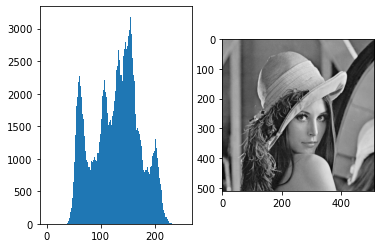

In [7]:
xmin, xmax = (0, 255)
nbins = 255

# Reset histogram
histogram_out = np.zeros(nbins)

# We're not timing the function, so just call it once to get the histogram
kernel_2D[(4, 4), (16, 16)](image_array_gs, xmin, xmax, histogram_out)


# Calculate x-axis values for plotting reasons (we also need to recalculate the bin width)
bin_width = (xmax - xmin) / nbins
x_vals = np.linspace( xmin, xmax, nbins, endpoint=False ) + bin_width/2

# Plot the histogram and image
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.bar( x_vals, histogram_out, width=bin_width )
ax2.imshow(image_array_gs, cmap='gray')
plt.show()

In [8]:
from Helpers import synchronous_kernel_timeit as sync_timeit

t = sync_timeit( lambda: kernel_2D[(4, 4), (16, 16)](image_array_gs, xmin, xmax, histogram_out), number=10)

print( t )

0.006498813629150391


That's it! Regardles of how many threads we allocate to the task, they are going to cover the entire image. However, depending on their number, we can then expect the processing time to fluctuate accordingly.

#### Using a 3D grid (RGB)

Taking the same approach to increase the grid dimensions, let's now calculate the histogram of the RGB image in parallel. When calling the kernel we leave the number of threads per kernel untouched and add two more layers of thread blocks in the Z-axis. Consequently we get tripple the amount of threads, compared to the grayscale example.

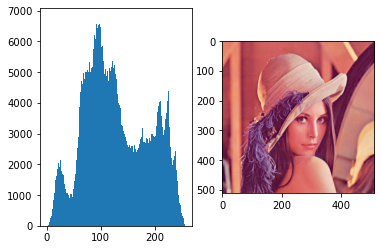

In [9]:
@cuda.jit
def kernel_3D(samples, xmin, xmax, histogram_out):
    '''Use the GPU for generateing a histogram of 3D input data (RGB).'''

    # Calculate the thread's absolute position within the grid
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    z = cuda.threadIdx.z + cuda.blockIdx.z * cuda.blockDim.z

    # Set stride equal to the number of threads we have available in either direction
    stride_x = cuda.gridDim.x * cuda.blockDim.x
    stride_y = cuda.gridDim.y * cuda.blockDim.y
    stride_z = cuda.gridDim.z * cuda.blockDim.z

    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins

    for i in range(x, samples.shape[0], stride_x):
        for j in range(y, samples.shape[1], stride_y):
            for k in range(z, samples.shape[2], stride_z):
                bin_number = int((samples[i, j, k] - xmin) / bin_width)
                if bin_number >= 0 and bin_number < histogram_out.shape[0]:
                    cuda.atomic.add(histogram_out, bin_number, 1)  # Prevent race conditions
                    

# Reset histogram
histogram_out = np.zeros(nbins)

# We're not timing the function, so just call it once to get the histogram
kernel_3D[(4, 4, 3), (16, 16, 1)](image_array, xmin, xmax, histogram_out)


# Plot the histogram and image
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.bar( x_vals, histogram_out, width=bin_width )
ax2.imshow(image_array)
plt.show()

Lastly, calculating the speed uncovers a slight anomaly:

In [10]:
from Helpers import synchronous_kernel_timeit as sync_timeit

t = sync_timeit( lambda: kernel_3D[(4, 4, 3), (16, 16, 1)](image_array, xmin, xmax, histogram_out), number=10)

print( t )

0.013437652587890625


Ouch! Although we made sure that every data sample had its own thread, the calculation time increased. Normally one expects this to happen when the 2D matrices of the three colors are processed in sequence. 

The reason for the time increase is that we are performing *safe* or *blocking* writeoperations on the output histogram array. In our case, we now have a 67 % increase in such operations (two additional color matrices). Therefore, the time increase is expected behaviour. What we have yet to determine is, how does the number of threads and kernels influence the end processing time?

## Thread warps and CUDA cores

And a small part of you imagination just dissapeared...

<div style="display: flex" >
<img src="./Image/star-trek-warp.jpeg" alt="Star trek." style="height: 150px; margin: 20px; float: left"/>
<img src="./Image/captain-kirk.jpg" alt="Star trek." style="height: 150px; margin: 20px; float: left"/>
<img src="./Image/warp-knitting.png" alt="Warp in knitting." style="height: 150px; margin: 20px; float: left"/>
<img src="./Image/flock-of-sheep.jpg" alt="Flock of sheep." style="height: 150px; margin: 20px; float: left"/>
</div>
    
Aye captain, that's the warp we're talking about! Sorry if you thought a warp was something cooler and respect for the sheep population.

In CUDA terms, a **warp** is a unit consisting of **32 threads** that are execuded on a single CUDA core. The threads therein all execute the same instruction set. Regardless of how many threads are defined in a kernel function call, a multiple of 32 threads is always assigned to it. Unless explicityl defined during the kernel function call, the redundant threads - also called idle threads - don't contribute to the computing. The below figure illustrates a stream multiprocessor (SM) in the Nvidia Fermi architecture.

<img src="./Image/multiprocessor.png" alt="Fermi stream multiprocessor." style="width: 600px; margin: 20px;"/>

Other architectures might have different layouts and numbers of individual components, but what unites them is the fact that they all have CUDA cores and they offer the most throughput when entire warps are utilized. To evaluate what happens, we need to run over multiple thread-block configurations and time the kernel. Below is a basic example of how this can be done.

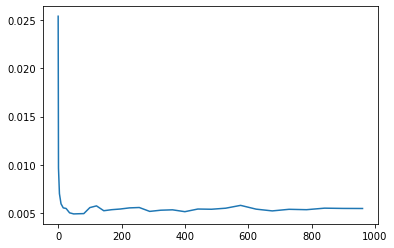

In [12]:
th = 10
execution_times = []

for i in range(32):
    t = sync_timeit( lambda: kernel_2D[(4, 4), (1+i, 1+i)](image_array_gs, xmin, xmax, histogram_out), number=10)
    execution_times.append(t)

plt.plot( [i**2 for i in range(len(execution_times))], execution_times )
plt.show()

Unsurprisingly, increasing the amount of threads resuces the processing time. However, there is some jitter-like inconsistency present in the results. A more detailed study is needed to fully assess the dependency between execution times and thread count, while taking into account warp utilization.

## Assignment - Generating an image


### Helpers and pointers

Your goal is to generate a 2D image on the GPU, such as the one described by:

$px[i, j] = (\sin{\dfrac{i \cdot 2.0 \pi}{T}} + 1.0) \cdot (\sin{\dfrac{j \cdot 2.0 \pi}{T}} + 1.0) \cdot \dfrac{1}{4}$


### Report and deadline

*Follow the bellow insructions and write a report when done. Explain what you have learned and critically assess the performance of your code. The report shouldn't exceed 3 pages (including figures). If you wish to share your code, include a link to the corresponding repository in your report or write the report in the form of a Notebook.*

*Hand in your reports to alexander.marinsek@kuleuven.be by:*
* *SA & GS: Sunday, xx/xx/2021, 23:59 CExT*
* *ES: Sunday, xx/xx/2021, 23:59 CExT*


### Instructions

##### I. Striding

1. Design an image-generating kernel for 1024 px square images using the equation 

$px[i, j] = (\sin{\dfrac{i \cdot 2.0 \pi}{T}} + 1.0) \cdot (\sin{\dfrac{j \cdot 2.0 \pi}{T}} + 1.0) \cdot \dfrac{1}{4}$

2. Test it using 1024$^2$ threads. Choose the block size and number of threads per block accordingly. Keep in mind the threads per block limit (1024 on the GT 730). 
3. Now use only a quarter of the threads - without striding - and observe the plotted image. What hapens, and what would happen if you had too many threads?
4. Overcome the problem using striding - one thread may process multiple pixels.
5. Run it again and verify the entire image is rendered. Graphically and in words, how would you describe striding?


##### II. Leveraging warps 

1. Evaluate how the kernel behaves when increasing the total number of threads and the amount of threads per block. 
2. Plot and discuss the dependency of the computational time on the number of threads. Are there any peculiarities and pitfalls one must keep in mind when running a kernel function?
3. (optional) Insert the statement `histogram_out_device = cuda.to_device(histogram_out)` before calling the kernel and this time pass it the `histogram_out_device` array. What happens and how is it manifested on the performance?

### Further reading

* (Stride loop) Introduction to Parallel Programming with CUDA and C++: https://medium.com/@avinkavish/introduction-to-parallel-programming-with-cuda-and-c-ff2ca339aca
* (Stream multiprocessor architecture) Computer Organization and Architecture, chapter 19.3: http://williamstallings.com/COA/
* (Lenna) Story behind the photo and full pic: https://datafireball.com/2016/09/24/lena-the-origin-about-the-de-facto-test-image/